In this section we will provide the results from four modeling approaches.  Three of these 
modeling approaches are defined for you, and you get to choose the fourth approach from the 
list of choices.   
    - For each model provide any relevant or useful model output and a table of the model
    performance in-sample (i.e. on the training data set) and out-of-sample (i.e. on the test data set).   
    - The metrics to be measured are:   
        (1) true positive rate or sensitivity  
        (2) false positive rate  
        (3) the accuracy.  
 
5.a Random Forest  
    - Include the variable importance plot.  
 
5.b Gradient Boosting  
    - Use GBM or XGBoost packages.  Include the variable importance plot.  

5.c Logistic Regression with Variable Selection   
    - Random Forest and Gradient Boosting will identify a pool of interesting predictor 
    variables.  Use that information to help you choose an initial pool of predictor variables.   
    List your initial pool of predictor variables in a table.   
    - Choose a variable selection algorithm.  Use that variable selection algorithm to arrive at 
    an ‘optimal’ logistic regression model.  
    - Since this is a linear model, you should provide a table of the model coefficients and 
    their p-values.  
 
5.d Your Choice – CHAID, Neural Network, SVM, or some other method appropriate for 
binary classification.   
    - Provide the relevant output for the model of choice.  For example SVM has margin 
    plots that are useful, and a neural network allows you to plot out the network topology.  If 
    your chosen method has a ‘standard’ plot that is typically shown with it, then we all 
    expect to see that plot, and you should be providing that plot with the model.

In [3]:
### ref https://blog.jovian.ai/machine-learning-with-python-implementing-xgboost-and-random-forest-fd51fa4f9f4c#b9a9
# !pip install numpy pandas matplotlib seaborn --quiet
# !pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet
# !pip install pyreadr

#importing dataset
import os
# import opendatasets as od
import pandas as pd
import numpy as np
import pyreadr

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# For Missing Value and Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn import metrics

import time

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)


In [4]:
credit_card_default_raw = pd.read_csv('./Data/credit_card_default.csv')
# credit_card_default_eng = pd.read_csv('./Data/credit_card_default_eng.csv')
result = pyreadr.read_r('./Data/credit_card_default_eng_features.RData') 
credit_card_default_eng = result[None]
# credit_card_default_eng.set_index('Unnamed: 0', inplace=True)
display(credit_card_default_eng.describe())
display(credit_card_default_eng.head())

,age_bins,bill_avg,payment_avg,ratio_avg,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max
count,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,3.000000e+04,30000.000000
mean,3.99390,44976.945200,5275.232094,0.576423,0.375468,-0.090664,6.057244e+04,1.584823e+04,0.682200
std,0.95845,63260.721860,10137.946323,16.499616,0.355618,0.279674,7.840481e+04,3.793356e+04,1.073518
min,3.00000,-56043.166667,0.000000,0.000000,-0.232590,-4.700400,-6.029000e+03,0.000000e+00,0.000000
25%,3.00000,4781.333333,1113.291667,0.047855,0.028925,-0.146863,1.006000e+04,2.198000e+03,0.000000
50%,4.00000,21051.833333,2397.166667,0.197668,0.286554,-0.004382,3.120850e+04,5.000000e+03,0.000000
75%,5.00000,57104.416667,5583.916667,0.903817,0.692718,0.028105,7.959900e+04,1.210000e+04,2.000000
max,8.00000,877313.833333,627344.333333,2667.199955,5.537758,1.791100,1.664089e+06,1.684259e+06,8.000000


,age_bins,bill_avg,payment_avg,ratio_avg,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max
0,3.0,1284.000000,114.833333,0.800000,0.064200,-0.195650,3913.0,689.0,2.0
1,3.0,2846.166667,833.333333,0.193583,0.023987,0.006442,3455.0,2000.0,2.0
2,4.0,16942.166667,1836.333333,0.083968,0.187133,-0.158789,29239.0,5000.0,0.0
3,4.0,38555.666667,1398.000000,0.039794,0.769153,-0.360620,49291.0,2019.0,0.0
4,6.0,18223.166667,9841.500000,0.471997,0.364513,0.210580,35835.0,36681.0,0.0


In [5]:
# clean data?
credit_card_default = credit_card_default_eng.copy()
df_flags = credit_card_default_raw[['data.group', 'DEFAULT']]
credit_card_default = credit_card_default.join(df_flags)
credit_card_default

,age_bins,bill_avg,payment_avg,ratio_avg,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max,data.group,DEFAULT
0,3.0,1284.000000,114.833333,0.800000,0.064200,-0.195650,3913.0,689.0,2.0,1,1
1,3.0,2846.166667,833.333333,0.193583,0.023987,0.006442,3455.0,2000.0,2.0,3,1
2,4.0,16942.166667,1836.333333,0.083968,0.187133,-0.158789,29239.0,5000.0,0.0,1,0
3,4.0,38555.666667,1398.000000,0.039794,0.769153,-0.360620,49291.0,2019.0,0.0,3,0
4,6.0,18223.166667,9841.500000,0.471997,0.364513,0.210580,35835.0,36681.0,0.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...
29995,4.0,120891.500000,7091.666667,0.121471,0.561065,-0.716868,208365.0,20000.0,0.0,1,0
29996,5.0,3530.333333,2415.000000,0.807750,0.029302,0.023380,8979.0,8998.0,0.0,3,0
29997,4.0,11749.333333,5216.666667,0.272225,0.398450,0.567233,20878.0,22000.0,4.0,2,1
29998,5.0,44435.166667,24530.166667,0.481511,0.478171,0.168750,78379.0,85900.0,1.0,1,1


Prep for modeling

0    23364
1    23364
Name: DEFAULT, dtype: int64


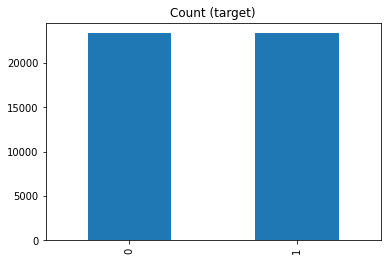

In [6]:
# Fix imbalance
count_class_0, count_class_1 = credit_card_default.DEFAULT.value_counts()

df_class_0 = credit_card_default[credit_card_default.DEFAULT == 0]
df_class_1 = credit_card_default[credit_card_default.DEFAULT == 1]

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)
df_test_over.drop(columns=['age_bins'],inplace=True)

print(df_test_over.DEFAULT.value_counts())

df_test_over.DEFAULT.value_counts().plot(kind='bar', title='Count (target)');


In [7]:
ccd_train = df_test_over[df_test_over['data.group']==1].drop(columns=['data.group'])
ccd_test = df_test_over[df_test_over['data.group']==2].drop(columns=['data.group'])
ccd_validate = df_test_over[df_test_over['data.group']==3].drop(columns=['data.group'])

print('train data size:', ccd_train.shape)
print('test data size:', ccd_test.shape)
print('validate data size:', ccd_validate.shape)

train data size: (23775, 9)
test data size: (11160, 9)
validate data size: (11793, 9)


In [9]:
X_train = ccd_train[['pay_max', 'payment_avg', 'payment_max', 'ratio_avg', 'balance_growth_6mo']]
X_test = ccd_test[~ccd_test.index.duplicated(keep='first')][['pay_max', 'payment_avg', 'payment_max', 'ratio_avg', 'balance_growth_6mo']]
X_val = ccd_validate[~ccd_validate.index.duplicated(keep='first')][['pay_max', 'payment_avg', 'payment_max', 'ratio_avg', 'balance_growth_6mo']]

y_train = ccd_train['DEFAULT']
y_test = ccd_test[~ccd_test.index.duplicated(keep='first')]['DEFAULT']
y_val = ccd_validate[~ccd_validate.index.duplicated(keep='first')]['DEFAULT']


In [10]:
all_features = X_train.columns
all_features = all_features.tolist()

In [11]:
numerical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind in ['i','f']]
display(numerical_features)
categorical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind not in ['i','f']]
display(categorical_features)

['pay_max', 'payment_avg', 'payment_max', 'ratio_avg', 'balance_growth_6mo']

[]

In [12]:
preprocessor = make_column_transformer(
    
    (make_pipeline(
    SimpleImputer(strategy = 'median'),
    # KNNImputer(n_neighbors=2, weights="uniform"),
    MinMaxScaler()), numerical_features),
    
    (make_pipeline(
    SimpleImputer(strategy = 'constant'),  # ValueError: 'fill_value'=missing is invalid. Expected a numerical value when imputing numerical data
    OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features),
    
)

In [13]:
preprocessor_best = make_pipeline(preprocessor, 
                                  VarianceThreshold(), 
                                  SelectKBest(f_classif, k = 'all')
                                 )


5.c LR

In [14]:
%%time
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model.fit(X_train, y_train)


CPU times: total: 78.1 ms
Wall time: 123 ms


LogisticRegression()

In [15]:
np.round(model.coef_,2)

array([[ 0.55, -0.  ,  0.  , -0.11, -0.  ]])

In [17]:
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression

def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

# test p-values
x = np.arange(10)[:, np.newaxis]
y = np.array([0,0,0,1,0,0,1,1,1,1])
print(logit_pvalue(model, X_train))


[1.70360300e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.31572927e-04 9.89020816e-01]


,precision,recall,f1-score,support
0,0.89,0.74,0.81,5766.00
1,0.40,0.66,0.50,1500.00
accuracy,0.73,0.73,0.73,0.73
macro avg,0.65,0.70,0.66,7266.00
weighted avg,0.79,0.73,0.75,7266.00


[[4276 1490]
 [ 503  997]]


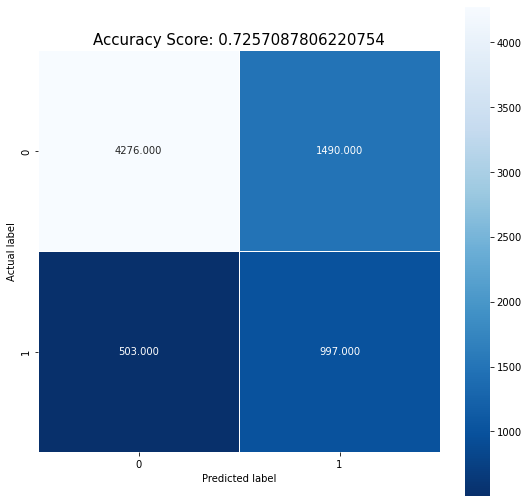

In [18]:
# Ref: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions = model.predict(X_test)
score = model.score(X_test, y_test)
# print(classification_report(y_test, predictions))
report = classification_report(y_test, predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
display(df.round(2))

cm = confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


#### KS & ROC

In [19]:
def run_preds(model, x):
    prob_predictions = model.predict_proba(x)
    df = pd.DataFrame(prob_predictions)
    df['p'] = df.max(axis=1)
    df['y'] = df.idxmax(axis=1)
    return df

In [20]:
# Ref: https://www.listendata.com/2019/07/KS-Statistics-Python.html
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 20)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.abs(np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100)

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,21)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 100)
    print(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)



In [21]:
from sklearn.metrics import roc_curve,roc_auc_score

def plot_roc_curve(df): 
  fpr , tpr , thresholds = roc_curve( df.y , df.p)
  auc_score=roc_auc_score(df.y , df.p) 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.text(x=.1,y=.8,s="ROC curve (area = %0.2f)" % auc_score)
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  
  plt.show() 
  

#### Train

In [22]:
df_train = run_preds(model, X_train)

In [23]:
df_tr = ks(data=df_train,target="y", prob="p")
df_tr

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.847361  1.000000     621        567      5.80%         4.34%   
2       0.789447  0.847201     873        317      8.15%         2.43%   
3       0.751708  0.789324     867        322      8.09%         2.47%   
4       0.745929  0.751694    1148         40     10.71%         0.31%   
5       0.739833  0.745928    1126         63     10.51%         0.48%   
6       0.731642  0.739803    1088        101     10.15%         0.77%   
7       0.714909  0.731622    1024        162      9.56%         1.24%   
8       0.691021  0.714889     859        328      8.02%         2.51%   
9       0.657596  0.690936     662        531      6.18%         4.07%   
10      0.630473  0.657556     349        626      3.26%         4.79%   
11      0.618600  0.630473    1027        374      9.58%         2.86%   
12      0.594564  0.618599     304    

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.847361,1.000000,621,567,5.80%,4.34%,5.80%,4.34%,1.5
2,0.789447,0.847201,873,317,8.15%,2.43%,13.94%,6.77%,7.2
3,0.751708,0.789324,867,322,8.09%,2.47%,22.03%,9.23%,12.8
4,0.745929,0.751694,1148,40,10.71%,0.31%,32.75%,9.54%,23.2
5,0.739833,0.745928,1126,63,10.51%,0.48%,43.26%,10.02%,33.2
6,0.731642,0.739803,1088,101,10.15%,0.77%,53.41%,10.80%,42.6
7,0.714909,0.731622,1024,162,9.56%,1.24%,62.97%,12.04%,50.9
8,0.691021,0.714889,859,328,8.02%,2.51%,70.98%,14.55%,56.4
9,0.657596,0.690936,662,531,6.18%,4.07%,77.16%,18.61%,58.5


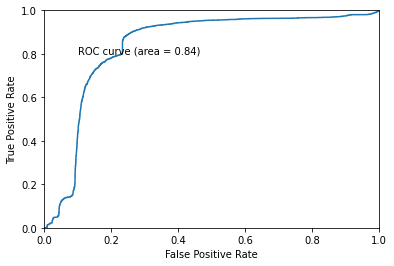

In [24]:

plot_roc_curve (df_train) 


#### Test

In [25]:
df_test = run_preds(model, X_test)

In [26]:
df_te = pd.DataFrame(ks(data=df_test,target="y", prob="p"))
df_te

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.844020  1.000000     132        232      5.31%         4.85%   
2       0.761118  0.843945     172        191      6.92%         4.00%   
3       0.748044  0.761095     316         47     12.71%         0.98%   
4       0.740543  0.748020     336         27     13.51%         0.56%   
5       0.728590  0.740524     312         52     12.55%         1.09%   
6       0.708947  0.728516     267         96     10.74%         2.01%   
7       0.680528  0.708897     210        153      8.44%         3.20%   
8       0.652125  0.680519     116        247      4.66%         5.17%   
9       0.630474  0.652074      63        225      2.53%         4.71%   
10      0.615234  0.630473     258        181     10.37%         3.79%   
11      0.595886  0.615219      75        288      3.02%         6.03%   
12      0.575906  0.595753      56    

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.844020,1.000000,132,232,5.31%,4.85%,5.31%,4.85%,0.5
2,0.761118,0.843945,172,191,6.92%,4.00%,12.22%,8.85%,3.4
3,0.748044,0.761095,316,47,12.71%,0.98%,24.93%,9.83%,15.1
4,0.740543,0.748020,336,27,13.51%,0.56%,38.44%,10.40%,28.0
5,0.728590,0.740524,312,52,12.55%,1.09%,50.99%,11.49%,39.5
6,0.708947,0.728516,267,96,10.74%,2.01%,61.72%,13.50%,48.2
7,0.680528,0.708897,210,153,8.44%,3.20%,70.16%,16.70%,53.5
8,0.652125,0.680519,116,247,4.66%,5.17%,74.83%,21.87%,53.0
9,0.630474,0.652074,63,225,2.53%,4.71%,77.36%,26.57%,50.8


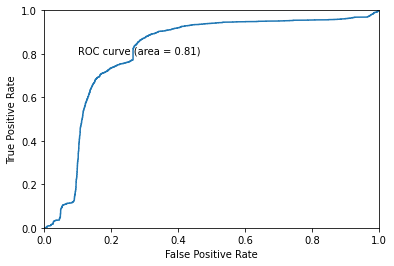

In [27]:

plot_roc_curve (df_test) 


#### Validate

In [28]:
df_val = run_preds(model, X_val)

In [29]:
df_te = pd.DataFrame(ks(data=df_val,target="y", prob="p"))
df_te

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.844855  1.000000     129        244      5.21%         4.90%   
2       0.763020  0.844816     158        215      6.39%         4.31%   
3       0.748299  0.762923     332         41     13.42%         0.82%   
4       0.739267  0.748296     347         26     14.03%         0.52%   
5       0.726594  0.739214     310         62     12.53%         1.24%   
6       0.705583  0.726572     262        111     10.59%         2.23%   
7       0.676429  0.705561     197        176      7.96%         3.53%   
8       0.643865  0.676346     123        250      4.97%         5.02%   
9       0.628869  0.643736     199        174      8.04%         3.49%   
10      0.610942  0.628862     128        244      5.17%         4.90%   
11      0.590840  0.610860      72        301      2.91%         6.04%   
12      0.572703  0.590802      38    

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.844855,1.000000,129,244,5.21%,4.90%,5.21%,4.90%,0.3
2,0.763020,0.844816,158,215,6.39%,4.31%,11.60%,9.21%,2.4
3,0.748299,0.762923,332,41,13.42%,0.82%,25.02%,10.03%,15.0
4,0.739267,0.748296,347,26,14.03%,0.52%,39.05%,10.56%,28.5
5,0.726594,0.739214,310,62,12.53%,1.24%,51.58%,11.80%,39.8
6,0.705583,0.726572,262,111,10.59%,2.23%,62.17%,14.03%,48.1
7,0.676429,0.705561,197,176,7.96%,3.53%,70.13%,17.56%,52.6
8,0.643865,0.676346,123,250,4.97%,5.02%,75.10%,22.58%,52.5
9,0.628869,0.643736,199,174,8.04%,3.49%,83.14%,26.07%,57.1


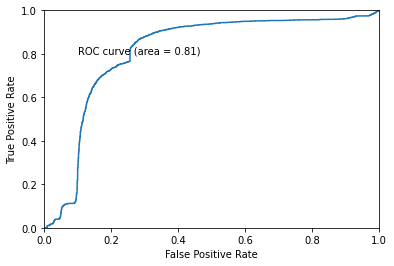

In [30]:

plot_roc_curve (df_val) 
